# Word Embeddings for Sentiment Analysis with IMDB Reviews

This lab explores the concept of word embeddings and their pivotal role in natural language processing (NLP) tasks, specifically:

**Objective**: Analyze the role of word embeddings in performing sentiment analysis on IMDB movie reviews, understanding how these embeddings represent semantic relationships between words.

**Focus Areas**:
- Learn about embedding layers and their integration into machine learning models.
- Visualize word embeddings to uncover patterns and relationships in the data.
- Work with pre-trained embeddings to enhance the performance of sentiment analysis models.

By the end of this lab, you'll gain hands-on experience with key techniques that underpin modern NLP solutions.



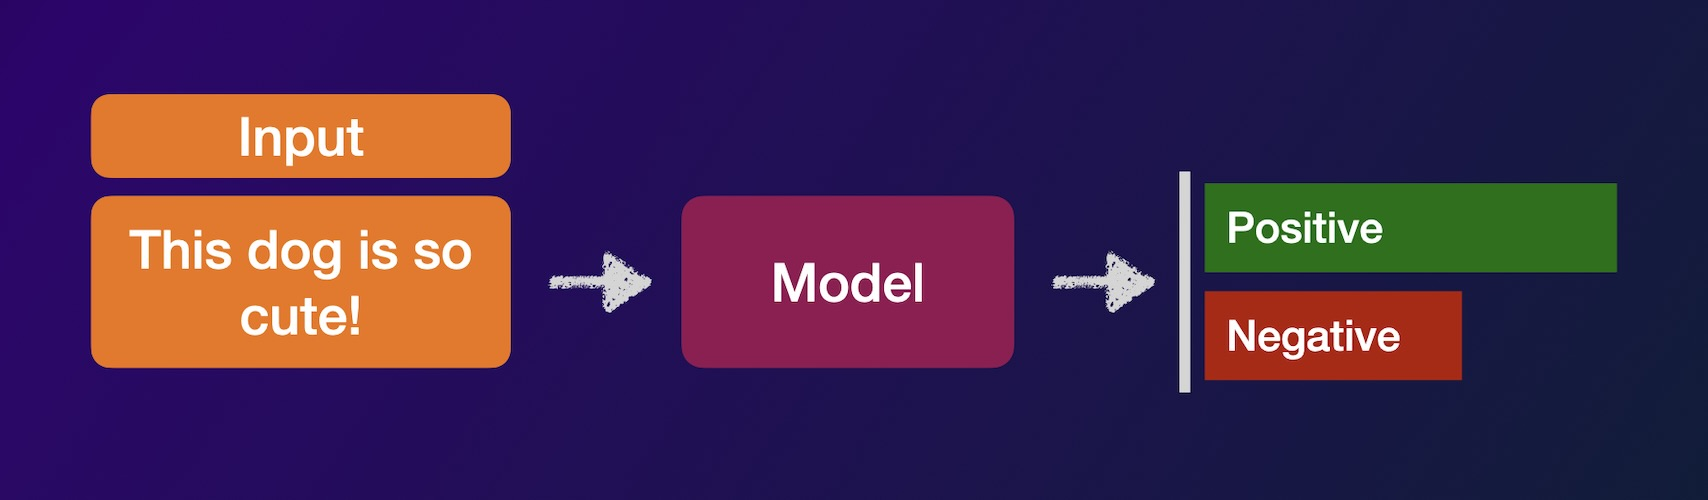

## 0. Setup
First, install the necessary libraries.

In [ ]:
!pip install datasets torchtext==0.15.2 torch torchvision pytorch-lightning torchmetrics gensim scikit-learn

## 1. Data Preparation

### Load the Dataset

Load the IMDB dataset, the Large Movie Review Dataset, a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. Each example has a sentence (the text of the review) and a label (0/1) representing the positive or negative sentiment.

Here's an example of the data schema:
```
{
    "label": 0,
    "text": "Goodbye world2\n"
}
```

Load the IMDB dataset at URL https://huggingface.co/datasets/stanfordnlp/imdb  using the HuggingFace library `datasets`.

In [ ]:
from datasets import load_dataset
from pprint import pprint

# Load the IMDB dataset from HuggingFace's datasets library
dataset = load_dataset("stanfordnlp/imdb")

# Print dataset information
print("Dataset structure:")
print(dataset)

# Print an example from the dataset
example = dataset['train'][11]
print("\nExample data schema:")
pprint(example)

Split the dataset into train, validation and test sets.and create a new version `dataset_split` containing the three splits.

In [ ]:
import random
from datasets import DatasetDict

SEED = 0

# Split dataset into train, validation, and test
# We reduce the number of examples to speed up the process
NUM_EXAMPLE = 10000
train_data = dataset['train'].shuffle(seed=SEED).select(range(NUM_EXAMPLE))
test_data = dataset['test'].shuffle(seed=SEED).select(range(NUM_EXAMPLE))

# Split test dataset into validation and test (50/50 split)
# Set random seed for reproducibility
random.seed(SEED)
test_data, valid_data = test_data.train_test_split(test_size=0.5, seed=SEED).values()

# Create a new DatasetDict
dataset = DatasetDict({
    'train': train_data,
    'validation': valid_data,
    'test': test_data
})

print(dataset)

### Preproces the Dataset
For each review in the corpus, apply a preprocessing similar to the one of the previous lab, consisting in:

- **Tokenization**: Each sentence is split into words that are seperated by the punctuation.

- **Lowercasing**: Each word is lowercased, thus reducing the final vocabulary.

- **Lemmatization**: Each word is replaced by its lemma form. Lemmatization reduces vocabulary size as all different forms of a word are grouped in a single lemma.

- **Remove stop words**: In order to reduce sentence length and represent the words that carry the meaning of the sentence, we remove all stop words.

> Note the use of the `nltk` library to define preprocessing pipeline and the use of the HuggingFace datasets `map()` method to significantly speed up processing functions.



In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np

# Initialize stopwords for English and the WordNet lemmatizer
STOP_WORDS = set(stopwords.words('english'))  # Use a set for faster lookup
LEMMATIZER = WordNetLemmatizer()

def preprocess_example(example):
    """
    Preprocess a single example for use with the Hugging Face datasets map method.

    Steps:
    1. Tokenize the text using NLTK's word tokenizer.
    2. Convert words to lowercase.
    3. Remove stopwords.
    4. Lemmatize words.

    Args:
    - example (dict): A dictionary containing a "text" field with the sentence to process.

    Returns:
    - dict: A dictionary with the text replaced by preprocessed tokens.
    """
    # Tokenize the text
    words = word_tokenize(example['text'])

    # Preprocess words: lowercase, remove stopwords, and lemmatize
    preprocessed_tokens = [
        LEMMATIZER.lemmatize(word.lower())
        for word in words
        if word.lower() not in STOP_WORDS
    ]

    # Return the updated example with tokens
    return {"tokens": preprocessed_tokens}

# Apply preprocessing to the dataset
dataset = dataset.map(
    preprocess_example,
    num_proc=4  # Use multiprocessing for efficiency
)

### Prepare Vocabulary
Compute the vocabulary from the training sentences.  To speed up this example only the 25000 most frequent words would be included in the vocabulary, but other values could be selected.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
import torch

# Define constants
MAX_TOKENS = 25000  # Limit the maximum size of the vocabulary
SPECIAL_TOKENS = ["<unk>"]  # Special tokens for handling unknown words

def yield_tokens(data_iter, token_field="tokens"):
    """
    Generator to yield tokens from a dataset for vocabulary building.

    Args:
    - data_iter (iterable): An iterable dataset (e.g., a training split).
    - token_field (str): The key in the dataset containing the tokenized data.

    Yields:
    - list of str: Tokens from each example in the dataset.
    """
    for example in data_iter:
        yield example[token_field]

# Build the vocabulary from the training dataset
vocab = build_vocab_from_iterator(
    yield_tokens(dataset["train"], token_field="tokens"),
    specials=SPECIAL_TOKENS,
    max_tokens=MAX_TOKENS
)

# Set default index for unknown tokens
vocab.set_default_index(vocab["<unk>"])

# Print vocabulary statistics
print(f"Vocabulary size: {len(vocab)}")
print(f"First 10 tokens in vocabulary: {list(vocab.get_itos()[:50])}")


### Preparing DataLoaders

Convert the sentences into padded or truncated sequences of indices, making them ready for training in NLP models. This step ensures that all sequences have a uniform shape, which is essential for training models in frameworks like PyTorch or TensorFlow.


In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_batch(batch):
    """
    Collate function to prepare batches for the DataLoader.

    Args:
    - batch (list of dict): A batch of examples, where each example is a dictionary
                            containing "tokens" (list of str) and "label" (int or float).

    Returns:
    - padded_texts (torch.Tensor): A tensor of shape (batch_size, max_seq_length) with
                                   token indices padded to the same length.
    - labels (torch.Tensor): A tensor of shape (batch_size,) with labels as float values.
    """
    # Define processing pipelines for text and labels
    text_pipeline = lambda tokens: vocab(tokens)  # Convert tokens to indices using the vocabulary
    label_pipeline = lambda label: torch.tensor(label, dtype=torch.float)  # Convert labels to float tensors

    # Apply pipelines to create tensors for texts and labels
    text_tensors = [torch.tensor(text_pipeline(item["tokens"])) for item in batch]
    label_tensors = [label_pipeline(item["label"]) for item in batch]

    # Pad text sequences to the same length and convert labels to a tensor
    padded_texts = pad_sequence(text_tensors, batch_first=True)
    labels = torch.tensor(label_tensors)

    return padded_texts, labels

# Create DataLoaders for training and validation datasets
BATCH_SIZE = 64  # Define batch size

train_dataloader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle the training dataset for better generalization
    collate_fn=collate_batch  # Use the custom collate function
)

valid_dataloader = DataLoader(
    dataset["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle the validation dataset
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    dataset["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle the test dataset
    collate_fn=collate_batch
)

Show example of batches

In [ ]:
# Iterate through one batch of the training DataLoader
for batch_idx, (texts, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1} from the training DataLoader:")
    print(f"Texts (padded): \n{texts}")
    print(f"Labels: \n{labels}")

    # Stop after the first batch for illustration
    break

# Iterate through one batch of the validation DataLoader
for batch_idx, (texts, labels) in enumerate(valid_dataloader):
    print(f"\nBatch {batch_idx + 1} from the validation DataLoader:")
    print(f"Texts (padded): \n{texts}")
    print(f"Labels: \n{labels}")

    # Stop after the first batch for illustration
    break

## 2. Word Embeddings as the First Layer of a Neural Network


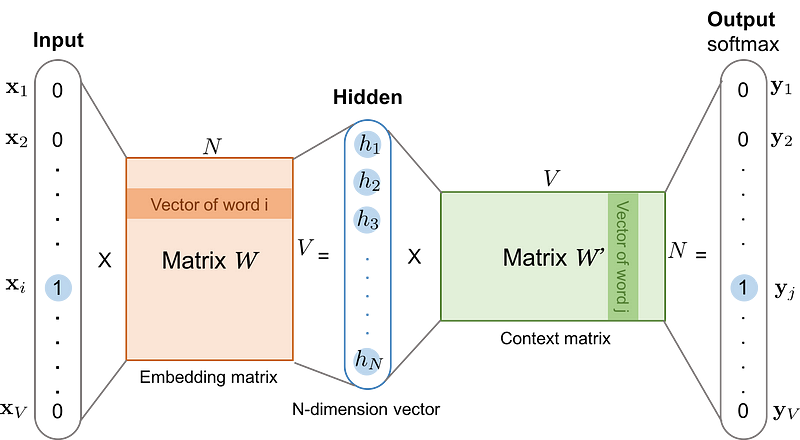

### Define the Model
The SentimentModel class is a PyTorch Lightning model designed for binary sentiment classification using text data, consisting of the following parts:

**Layers**
1. **Embedding Layer**: Converts token indices into dense vector representations (`nn.Embedding`).

2. **Global Max Pooling**: Applies adaptive max pooling (`nn.AdaptiveMaxPool1d`) over the embedded sequences to capture the most salient feature for each sentence.

3. **Fully Connected Layer**: A linear layer (`nn.Linear`) that maps the pooled features to the output dimension (1 for binary classification).

**Loss Function**: Binary Cross-Entropy with Logits (`nn.BCEWithLogitsLoss`) to compute the loss during training.

**Accuracy Metric**:
`torchmetrics.Accuracy` to compute accuracy during training, validation, and testing.

This model processes tokenized text data, embeds it, applies global max pooling, and passes the result through a fully connected layer for binary sentiment classification. It logs the loss and accuracy at each step (training, validation, and test), making it suitable for both training and evaluation in a PyTorch Lightning framework.

Note the use the PyTorch library `lightning` that simplify the implementation of the training loop by using the methods:

- `forward`: Defines the forward pass: embedding → pooling → fully connected layer.

- `training_step`: Computes loss for a batch and logs the training loss.

- `validation_step`: Computes loss and accuracy for a validation batch and logs these metrics.

- `test_step`: Computes loss and accuracy for a test batch and logs these metrics.

- `configure_optimizers`: Defines the optimizer (Adam) with a learning rate of 1e-3.

In [ ]:
# Define the Model
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

class SentimentModel(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim, output_dim, pretrained_embeddings=None, freeze_embeddings=True):
        super().__init__()
        # Check if pretrained embeddings are provided
        if pretrained_embeddings is not None:
            # Initialize embedding layer with pretrained embeddings
            self.embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,  # Pretrained weights
                freeze=freeze_embeddings  # Freeze or unfreeze the embeddings
            )
        else:
            # Initialize random embeddings if no pretrained embeddings are provided
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.pool = nn.AdaptiveMaxPool1d(1)  # Global max pooling
        self.fc = nn.Linear(embed_dim, output_dim)  # Linear layer for binary classification
        self.loss = nn.BCEWithLogitsLoss()  # Loss function for binary classification

        # Metric for evaluation
        self.accuracy = torchmetrics.Accuracy(task="binary")

    def forward(self, x):
        """
        Forward pass: Embedding -> Pooling -> Fully Connected Layer.
        """
        # TODO: Pass token indices through the embedding layer to get the embeddings and reshape them accordingly to the expected shape for `nn.AdaptiveMaxPool1d`
        embedded =

    def training_step(self, batch, batch_idx):
        """
        Single training step: Compute loss and log it.
        """
        texts, labels = batch
        logits = self(texts).squeeze(1)
        loss = self.loss(logits, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Single validation step: Compute loss and accuracy, log metrics.
        """
        texts, labels = batch
        logits = self(texts).squeeze(1)
        loss = self.loss(logits, labels)
        preds = torch.sigmoid(logits) > 0.5
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", self.accuracy(preds, labels), prog_bar=True)

    def test_step(self, batch, batch_idx):
        """
        Single test step: Compute loss and accuracy, log metrics.
        """
        texts, labels = batch
        logits = self(texts).squeeze(1)
        loss = self.loss(logits, labels)
        preds = torch.sigmoid(logits) > 0.5
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.accuracy(preds, labels), prog_bar=True)

    def configure_optimizers(self):
        """
        Define optimizer for training.
        """
        return torch.optim.Adam(self.parameters(), lr=1e-3)

### Train and evaluate the neural network
Use the processed IMDB data to train a sentiment classifier model.

In [ ]:
# Train and Evaluate the Model

# Initialize the model with appropriate dimensions
EMBED_DIM = 300  # the dimension of the vectors
OUTPUT_DIM = 1  # the dimension of the labels (binary in this case)
model = SentimentModel(vocab_size=len(vocab), embed_dim=EMBED_DIM, output_dim=OUTPUT_DIM)

# Initialize the PyTorch Lightning Trainer
NUM_EPOCHS = 5  # total number of epochs
trainer = pl.Trainer(max_epochs=NUM_EPOCHS)

# Train the model
trainer.fit(model, train_dataloader, valid_dataloader)


Evaluate the model on the test dataset

In [ ]:
trainer.test(model, test_dataloader)

## 3. Visualizing and Interpreting Learned Embeddings

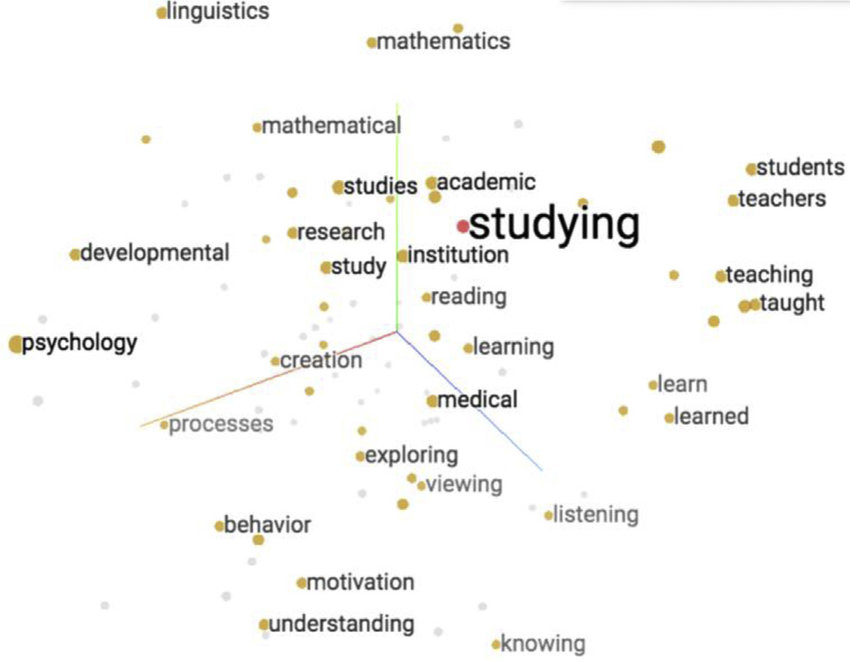

###  Explore the learned embeddings space
Extract the learned embeddings from the trained network's embedding layer. Then, reduce the dimensionality of the embeddings using PCA (to 2D) and visualize the embeddings in a 2D scatter plot.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# TODO: Extract the learned embeddings from the previous trained model
embedding_weights =

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_weights)

# Plot the reduced embeddings
def plot_embeddings(embeddings, vocab, num_words):
    plt.figure(figsize=(10, 10))
    words = list(vocab.get_itos()[:num_words])  # Get the top words in the vocabulary
    for i, word in enumerate(words):
        if i >= len(embeddings):
            break
        x, y = embeddings[i]
        plt.scatter(x, y)
        plt.text(x + 0.02, y + 0.02, word, fontsize=9)
    plt.title("2D Visualization of Word Embeddings")
    plt.show()


Visualize the embeddings of the top-k frequent words. Can you spot some pattern?

In [ ]:
# TODO: Visualize top 200 words


 ### Understanding How to Use Word Embeddings
 Load the embeddings with the `gensim` library, using the `KeyedVectors` class


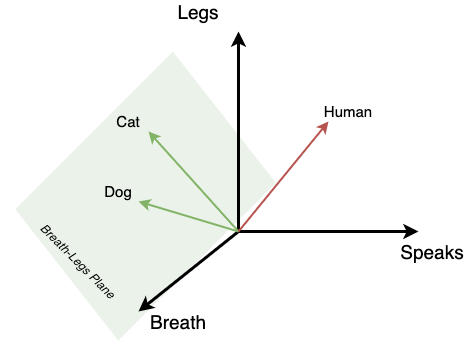

In [ ]:
from gensim.models import KeyedVectors


def create_gensim_vectors(vocab, embeddings):
    # TODO: # Convert embeddings into a KeyedVectors format for similarity calculations
    word_vectors =

    for idx, word in enumerate(vocab.get_itos()):
        word_vectors.add_vector(word, embeddings[idx])
    return word_vectors

# Create KeyedVectors instance
word_vectors = create_gensim_vectors(vocab, embedding_weights)

Find similar words using cosine similarity or `most_similar` function using the `gensim` library


In [ ]:
# Using cosine similarity to find similar words
def find_similar_words(word, topn=5):
    """
    Finds the most similar words to the given vector using cosine similarity.

    """
    if word in word_vectors.key_to_index:
        print(f"Top {topn} similar words to '{word}':")
        for similar_word, similarity in word_vectors.most_similar(word, topn=topn):
            print(f"  {similar_word}: {similarity:.2f}")
    else:
        print(f"'{word}' not in vocabulary.")

# Find similar words to a few selected terms
words = ["movie", "happy", "sad", "actor", "love"]
for word in words:
  # TODO: find most similar words


**Vector Aritmethic:** make analogies between words, the famous `king - man = queen - woman`

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_analogy(word1, word2, word3, word_vectors):
    """
    Computes the analogy: word1 - word2 + word3 = ? using embeddings from KeyedVectors.

    Args:
    word1 (str): The first word in the analogy (e.g., 'king').
    word2 (str): The second word in the analogy (e.g., 'man').
    word3 (str): The third word in the analogy (e.g., 'woman').
    word_vectors (gensim.models.KeyedVectors): Trained word embeddings.

    Returns:
    str: The word most similar to the analogy vector.
    float: The similarity score of the closest word.
    """
    # Ensure words are in vocabulary
    if not all(word in word_vectors for word in [word1, word2, word3]):
        raise ValueError("One or more words are not in the vocabulary.")

    # TODO: Compute the analogy vector
    analogy_vector =

    # Find the most similar word, excluding the input words
    most_similar = word_vectors.most_similar(positive=[word1, word3], negative=[word2], topn=10)
    for word, similarity in most_similar:
        if word not in [word1, word2, word3]:
            return word, similarity

    # Return a default in case no word is found
    return None, 0.0

Try with some words! Are the embeddings good enough to capture the analogies?

In [ ]:
# The classical, non sentiment-related, analogy: "king" - "man" + "woman" = ?
word1, word2, word3 = "king", "man", "woman"
result_word, similarity = compute_analogy(word1, word2, word3, word_vectors)
print(f"Analogy: {word1} - {word2} + {word3} = {result_word} (similarity: {similarity:.4f})")

In [ ]:
# TODO: A sentiment-related, analogy: "happy" - "positive" + "negative" = ?
word1, word2, word3 =
result_word, similarity =

print(f"Analogy: {word1} - {word2} + {word3} = {result_word} (similarity: {similarity:.4f})")

## 4. Leveraging Pre-trained Word2Vec Embeddings
- Compare the performance with the network that learned embeddings from scratch, including visualizations.
- Discuss the advantages and potential limitations of using pre-trained embeddings.



### Load pre-trained word embeddings
Use pre-trained Word2Vec embeddings using `gensim`, from the GloVe embeddings.


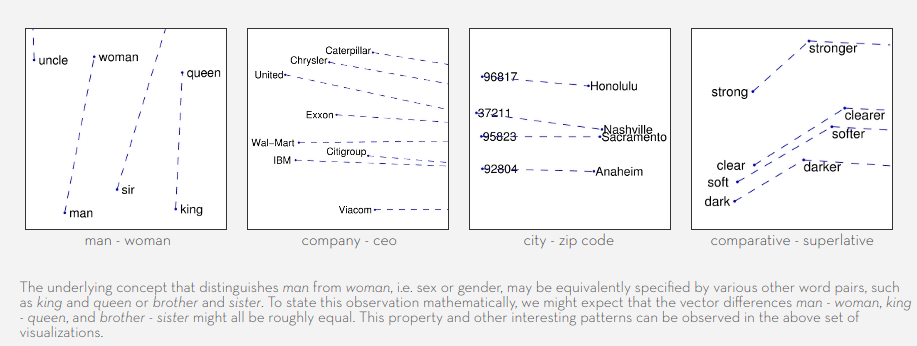

In [ ]:
# Download the GloVe embeddings (6B tokens, 100-dimensional vectors)
! wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded file
! unzip glove.6B.zip


In [ ]:
import gensim
from gensim.models import KeyedVectors

# Function to convert GloVe format to Word2Vec format
def convert_glove_to_word2vec(glove_file, word2vec_file):
    """
    Convert GloVe file to Word2Vec format.
    :param glove_file: Path to the GloVe file.
    :param word2vec_file: Path to save the Word2Vec formatted file.
    """
    # Load the GloVe embeddings directly using KeyedVectors.load_word2vec_format
    # and then save it in the desired format.
    model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True) # The glove file doesn't have a header
    model.save_word2vec_format(word2vec_file, binary=False)

# Paths to the GloVe embeddings and the converted Word2Vec file
glove_file_path = "glove.6B.300d.txt"  # Replace with your GloVe file path
word2vec_file_path = "glove.6B.300d.word2vec.txt"  # Path to save the converted file

# Convert GloVe to Word2Vec format
convert_glove_to_word2vec(glove_file_path, word2vec_file_path)

# Load the Word2Vec formatted embeddings
word_vectors_glove = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# Test the embeddings
print(word_vectors_glove.most_similar('king'))  # Replace 'king' with any word to test

Check again the analogy tasks: do they make sense now?

In [ ]:
# The classical, non sentiment-related, analogy: "king" - "man" + "woman" = ?
word1, word2, word3 = "king", "man", "woman"
result_word, similarity = compute_analogy(word1, word2, word3, word_vectors_glove)
print(f"Analogy: {word1} - {word2} + {word3} = {result_word} (similarity: {similarity:.4f})")

In [ ]:
# TODO: A sentiment-related, analogy: "happy" - "positive" + "negative" = ?
word1, word2, word3 =
result_word, similarity =

print(f"Analogy: {word1} - {word2} + {word3} = {result_word} (similarity: {similarity:.4f})")

### Train with pre-trained word vectors (freeze)
Replace the embedding layer of the neural network with the pre-trained embeddings and train the model again.

> Note: freeze the embeddings to keep their weights.

In [ ]:
# TODO: inject the sentiment analysis network with pre-trained from the GloVe vectors
# Hint1: extract the vectors from the gensim model and conver to tensors
embeddings_glove =

# TODO: Initialize the model with pre-trained embeddings
# Initialize the model with the pre-trained embeddings and freeze them
model_with_glove =

# Initialize the PyTorch Lightning Trainer
NUM_EPOCHS = 5
trainer = pl.Trainer(max_epochs=NUM_EPOCHS)

# Train the model
trainer.fit(model_with_glove_freeze, train_dataloader, valid_dataloader)


Evaluate on the test dataset: is the result better than the previous model?

In [ ]:
trainer.test(model_with_glove_freeze, test_dataloader)

### Train with pre-trained word vectors (no freezing)
Replace the embedding layer of the neural network with the pre-trained embeddings and train the model again.

> Note: this time, do not freeze the embeddings to adapt their weights.

In [ ]:
# TODO: inject the sentiment analysis network with pre-trained from the GloVe vectors
# Hint1: extract the vectors from the gensim model and conver to tensors
embeddings_glove =

# TODO: Initialize the model with pre-trained embeddings
# Initialize the model with the pre-trained embeddings but do not freeze them
model_with_glove =

# Initialize the PyTorch Lightning Trainer
NUM_EPOCHS = 5
trainer = pl.Trainer(max_epochs=NUM_EPOCHS)

# Train the model
trainer.fit(model_with_glove_unfreeze, train_dataloader, valid_dataloader)


Evaluate on the test dataset: is the result better than the previous model?

In [ ]:
trainer.test(model_with_glove_unfreeze, test_dataloader)